In [ ]:
# cd /content/drive/MyDrive/face_alignment

/content/drive/MyDrive/face_alignment


In [ ]:
# !git clone https://github.com/biubug6/Pytorch_Retinaface

In [1]:
import os
import torch
import torch.backends.cudnn as cudnn
import numpy as np
from data import cfg_mnet, cfg_re50
from layers.functions.prior_box import PriorBox
from utils.nms.py_cpu_nms import py_cpu_nms
import cv2
from models.retinaface import RetinaFace
from utils.box_utils import decode, decode_landm
from utils.timer import Timer

In [2]:
def check_keys(model, pretrained_state_dict):
    ckpt_keys = set(pretrained_state_dict.keys())
    model_keys = set(model.state_dict().keys())
    used_pretrained_keys = model_keys & ckpt_keys
    unused_pretrained_keys = ckpt_keys - model_keys
    missing_keys = model_keys - ckpt_keys
    print('Missing keys:{}'.format(len(missing_keys)))
    print('Unused checkpoint keys:{}'.format(len(unused_pretrained_keys)))
    print('Used keys:{}'.format(len(used_pretrained_keys)))
    assert len(used_pretrained_keys) > 0, 'load NONE from pretrained checkpoint'
    return True

In [3]:
def remove_prefix(state_dict, prefix):
    ''' Old style model is stored with all names of parameters sharing common prefix 'module.' '''
    print('remove prefix \'{}\''.format(prefix))
    f = lambda x: x.split(prefix, 1)[-1] if x.startswith(prefix) else x
    return {f(key): value for key, value in state_dict.items()}

In [4]:
def load_model(model, pretrained_path, load_to_cpu):
    print('Loading pretrained model from {}'.format(pretrained_path))
    if load_to_cpu:
        pretrained_dict = torch.load(pretrained_path, map_location=lambda storage, loc: storage)
    else:
        device = torch.cuda.current_device()
        pretrained_dict = torch.load(pretrained_path, map_location=lambda storage, loc: storage.cuda(device))
    if "state_dict" in pretrained_dict.keys():
        pretrained_dict = remove_prefix(pretrained_dict['state_dict'], 'module.')
    else:
        pretrained_dict = remove_prefix(pretrained_dict, 'module.')
    check_keys(model, pretrained_dict)
    model.load_state_dict(pretrained_dict, strict=False)
    return model

In [5]:
!ls

Copy_of_onnx.ipynb  convert_to_onnx.py	layers		   train.py
LICENSE.MIT	    curve		models		   utils
README.md	    data		test_fddb.py	   widerface_evaluate
app.ipynb	    detect.py		test_widerface.py


In [6]:
model_path = './models/Resnet50_Final.pth'

In [7]:
cfg_re50 = {
    'name': 'Resnet50',
    'min_sizes': [[16, 32], [64, 128], [256, 512]],
    'steps': [8, 16, 32],
    'variance': [0.1, 0.2],
    'clip': False,
    'loc_weight': 2.0,
    'gpu_train': True,
    'batch_size': 24,
    'ngpu': 4,
    'epoch': 100,
    'decay1': 70,
    'decay2': 90,
    'image_size': 840,
    'pretrain': True,
    'return_layers': {'layer2': 1, 'layer3': 2, 'layer4': 3},
    'in_channel': 256,
    'out_channel': 256
}


In [8]:
net = RetinaFace(cfg=cfg_re50, phase = 'test')
net = load_model(net, model_path, True)
net.eval()
print('Finished loading model!')
print(net)
device = torch.device("cpu")
net = net.to(device)

Loading pretrained model from ./models/Resnet50_Final.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:456
Finished loading model!
RetinaFace(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False

In [9]:
# output_onnx = 'FaceDetector.onnx'
# print("==> Exporting model to ONNX format at '{}'".format(output_onnx))
# input_names = ["input0"]
# output_names = ["output0"]
# inputs = torch.randn(1, 3, , 256).to(device)

# torch_out = torch.onnx._export(net, inputs, output_onnx, export_params=True, verbose=False,
#                                 input_names=input_names, output_names=output_names)

In [10]:
# # dummy_input = torch.randn(1, 376,376, requires_grad=True)  
# dummy_input = torch.randn(1, 3, 376, 376).to(device)

# # Export the model   
# torch.onnx.export(net,         # model being run 
#         dummy_input,       # model input (or a tuple for multiple inputs) 
#         "face_alignment_11.onnx",       # where to save the model  
#         export_params=True,  # store the trained parameter weights inside the model file 
#         opset_version=11,    # the ONNX version to export the model to 
#         do_constant_folding=True,  # whether to execute constant folding for optimization 
#         input_names = ['input0'],   # the model's input names 
#         output_names = ['output0'], # the model's output names 
#         dynamic_axes={'modelInput' : {0 : 'batch_size', 1: 'height', 2: 'width'},    # variable length axes 
#                             'modelOutput' : {0 : 'batch_size'}})

In [11]:
# !pip install onnx

In [12]:
# !pip install onnxruntime

In [13]:
url2 = 'https://toonapp.apyhi.com/facetoon/input_image/2022-02-23/test_2022-02-23T00:37:31.225930.jpg'

In [14]:
url2 = 'https://toonapp.apyhi.com/facetoon/input_image/2022-02-23/test_2022-02-23T01:57:41.844314.jpg'

In [15]:
url2 = 'https://toonapp.apyhi.com/facetoon/input_image/2022-02-23/test_2022-02-23T00:42:06.962563.jpg'

In [16]:
# two faces 
url2 = 'https://toonapp.apyhi.com/facetoon/input_image/2022-02-13/test_2022-02-13T02:32:31.086912.jpg'

In [17]:
url2 ='https://toonapp.apyhi.com/facetoon/input_image/2022-04-06/test_2022-04-06T00:33:31.331762.jpg'

In [18]:
url2 = 'https://toonapp.apyhi.com/facetoon/input_image/2022-02-15/test_2022-02-15T00:49:36.149936.jpg'

In [19]:
#no_image
url2 = 'https://toonapp.apyhi.com/revamp/facetoon/v_day/background/v_day_7_highres.jpg'

In [20]:
url2 = 'https://i.ibb.co/5Ljy7bb/2022-01-01-682.jpg'

In [76]:
url2 = 'https://i.ibb.co/Dfzk5qr/2022-01-01-426.jpg'

In [22]:
url2 = 'https://i.ibb.co/Yh3vm8T/2022-01-01-602.jpg'

In [23]:
import requests

## Bounding Box

In [77]:
from PIL import Image
import torchvision.transforms as transforms

img = Image.open(requests.get(url2, stream=True).raw).convert('RGB')
print(img.size)
#img = Image.open('/content/drive/MyDrive/facecartoon/face.jpg').convert('RGB').resize((500,400))
img_raw = np.array(img)
img = np.float32(img)

im_height, im_width, _ = img.shape
scale = torch.Tensor([img.shape[1], img.shape[0], img.shape[1], img.shape[0]])
img -= (104, 117, 123)
img = img.transpose(2, 0, 1)

(375, 500)


In [78]:
img = torch.from_numpy(img).unsqueeze(0)
img = img.to('cpu')
scale = scale.to('cpu')
loc, conf, landms = net(img)

In [79]:
loc.shape

torch.Size([1, 7842, 4])

In [80]:
conf.shape

torch.Size([1, 7842, 2])

In [81]:
landms.shape

torch.Size([1, 7842, 10])

In [82]:
d = {
    'loc': loc,
    'conf': conf,
    'landms': landms
}

In [83]:
# import pickle
# with open("bruh.pickle", 'wb') as fp:
#     pickle.dump(d, fp, pickle.HIGHEST_PROTOCOL)

In [84]:
pwd

'/mnt/e/projects/Utility/FaceDetection/Pytorch_Retinaface'

In [85]:
loc = loc.cpu().detach().numpy()
conf = conf.cpu().detach().numpy()
landms = landms.cpu().detach().numpy()

In [86]:
conf.shape

(1, 7842, 2)

In [87]:
from itertools import product as product
import numpy as np
from math import ceil


class PriorBox(object):
    def __init__(self, image_size=None, phase='train'):
        super(PriorBox, self).__init__()
        self.min_sizes = [[16, 32], [64, 128], [256, 512]]
        self.steps = [8, 16, 32]
        self.clip = False
        self.image_size = image_size
        self.feature_maps = [[ceil(self.image_size[0]/step), ceil(self.image_size[1]/step)] for step in self.steps]
        self.name = "s"

    def forward(self):
        anchors = []
        for k, f in enumerate(self.feature_maps):
            min_sizes = self.min_sizes[k]
            for i, j in product(range(f[0]), range(f[1])):
                for min_size in min_sizes:
                    s_kx = min_size / self.image_size[1]
                    s_ky = min_size / self.image_size[0]
                    dense_cx = [x * self.steps[k] / self.image_size[1] for x in [j + 0.5]]
                    dense_cy = [y * self.steps[k] / self.image_size[0] for y in [i + 0.5]]
                    for cy, cx in product(dense_cy, dense_cx):
                        anchors += [cx, cy, s_kx, s_ky]

        # back to torch land
        #output = torch.Tensor(anchors).view(-1, 4)
        output = np.array(anchors).reshape(-1, 4)
        if self.clip:
            output.clamp_(max=1, min=0)
        return output

In [88]:
priorbox = PriorBox(image_size=(im_height, im_width))

In [89]:
priors = priorbox.forward()

In [90]:
prior_data = priors

In [91]:
priors.shape

(7842, 4)

In [92]:
# priors = priors.to(device)

In [93]:
def decode(loc, priors, variances):
    """Decode locations from predictions using priors to undo
    the encoding we did for offset regression at train time.
    Args:
        loc (tensor): location predictions for loc layers,
            Shape: [num_priors,4]
        priors (tensor): Prior boxes in center-offset form.
            Shape: [num_priors,4].
        variances: (list[float]) Variances of priorboxes
    Return:
        decoded bounding box predictions
    """

    boxes = np.concatenate((
        priors[:, :2] + loc[:, :2] * variances[0] * priors[:, 2:],
        priors[:, 2:] * np.exp(loc[:, 2:] * variances[1])), 1)
    boxes[:, :2] -= boxes[:, 2:] / 2
    boxes[:, 2:] += boxes[:, :2]
    return boxes

In [94]:
scores = conf[0][:, 1]

In [95]:
boxes = decode(loc[0], prior_data, [0.1, 0.2])

In [96]:
boxes.shape

(7842, 4)

In [97]:
scale = scale.cpu().detach().numpy()

In [98]:
resize =1

In [99]:
boxes = boxes * scale / resize

In [100]:
def decode_landm(pre, priors, variances):
    """Decode landm from predictions using priors to undo
    the encoding we did for offset regression at train time.
    Args:
        pre (tensor): landm predictions for loc layers,
            Shape: [num_priors,10]
        priors (tensor): Prior boxes in center-offset form.
            Shape: [num_priors,4].
        variances: (list[float]) Variances of priorboxes
    Return:
        decoded landm predictions
    """
    landms = np.concatenate((priors[:, :2] + pre[:, :2] * variances[0] * priors[:, 2:],
                        priors[:, :2] + pre[:, 2:4] * variances[0] * priors[:, 2:],
                        priors[:, :2] + pre[:, 4:6] * variances[0] * priors[:, 2:],
                        priors[:, :2] + pre[:, 6:8] * variances[0] * priors[:, 2:],
                        priors[:, :2] + pre[:, 8:10] * variances[0] * priors[:, 2:],
                        ), axis=1)
    return landms

In [101]:
landms = decode_landm(landms[0], prior_data, [0.1, 0.2])

In [102]:
landms.shape

(7842, 10)

In [103]:
tmp = [img.shape[3], img.shape[2], img.shape[3], img.shape[2],
                               img.shape[3], img.shape[2], img.shape[3], img.shape[2],
                               img.shape[3], img.shape[2]]
scale1 = np.array(tmp, dtype=np.float32)
#scale1 = scale1.to(device)
landms = landms * scale1 / resize

In [104]:
# ignore low scores
inds = np.where(scores > 0.02)[0]
boxes = boxes[inds]
landms = landms[inds]
scores = scores[inds]

# keep top-K before NMS
#order = scores.argsort()[::-1][:5000]
order = scores.argsort()[::-1]
boxes = boxes[order]
landms = landms[order]
scores = scores[order]

In [105]:
def py_cpu_nms(dets, thresh):
    """Pure Python NMS baseline."""
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
    scores = dets[:, 4]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1]

    return keep

In [106]:
# do NMS
dets = np.hstack((boxes, scores[:, np.newaxis])).astype(np.float32, copy=False)
bounding_boxes = np.hstack((boxes, scores[:, np.newaxis])).astype(np.float32, copy=False)
keep = py_cpu_nms(dets, 0.4)
# keep = nms(dets, args.nms_threshold,force_cpu=args.cpu)
dets = dets[keep, :]
bounding_boxes = bounding_boxes[keep, :]

landms = landms[keep]

# keep top-K faster NMS
# dets = dets[:750, :]
# landms = landms[:750, :]

dets = np.concatenate((dets, landms), axis=1)
bboxes = np.concatenate((bounding_boxes, landms), axis=1)

In [107]:
print(bboxes.shape)

(1, 15)


## more configs

In [108]:
prior_data[0]

array([0.01066667, 0.008     , 0.04266667, 0.032     ])

In [109]:
# bbboxes = prior_data

# bbboxes[0] -= 100
# bbboxes[1] -= 100
# bbboxes[2] += 100
# bbboxes[3] += 100
# img_k = img_raw[int(bbboxes[1]):int(bbboxes[3]), int(bbboxes[0]):int(bbboxes[2]), :]

In [110]:
def get_center_face(det_faces, h=0, w=0, center=None):
    if center is not None:
        center = np.array(center)
    else:
        center = np.array([w / 2, h / 2])
    center_dist = []
    for det_face in det_faces:
        face_center = np.array([(det_face[0] + det_face[2]) / 2, (det_face[1] + det_face[3]) / 2])
        dist = np.linalg.norm(face_center - center)
        center_dist.append(dist)
    center_idx = center_dist.index(min(center_dist))
    return det_faces[center_idx], center_idx

In [111]:
eye_dist_threshold =5
all_landmarks_5 = []
det_faces = []
affine_matrices = []
cropped_faces=[]
only_keep_largest=False
only_center_face=True

In [112]:
face_size = 512
crop_ratio=(1, 1)
face_template = np.array([[192.98138, 239.94708], [318.90277, 240.1936], [256.63416, 314.01935],
                                           [201.26117, 371.41043], [313.08905, 371.15118]])
face_size_self = (int(face_size * crop_ratio[1]), int(face_size * crop_ratio[0]))

face_template = face_template * (face_size / 512.0)
if crop_ratio[0] > 1:
    face_template[:, 1] += face_size * (crop_ratio[0] - 1) / 2
if crop_ratio[1] > 1:
    face_template[:, 0] += face_size * (crop_ratio[1] - 1) / 2

In [113]:
def get_landmarks(bboxes, det_faces, all_landmarks_5,eye_dist_threshold=5):
    for bbox in bboxes:
        # remove faces with too small eye distance: side faces or too small faces
        eye_dist = np.linalg.norm([bbox[6] - bbox[8], bbox[7] - bbox[9]])
        if eye_dist_threshold is not None and (eye_dist < eye_dist_threshold):
            continue

        landmark = np.array([[bbox[i], bbox[i + 1]] for i in range(5, 15, 2)])
        all_landmarks_5.append(landmark)
        det_faces.append(bbox[0:5])
        
    if len(det_faces) == 0:
        return 0
    # if only_keep_largest:
    #     h, w, _ = self.input_img.shape
    #     self.det_faces, largest_idx = get_largest_face(self.det_faces, h, w)
    #     self.all_landmarks_5 = [self.all_landmarks_5[largest_idx]]
    elif only_center_face:
        #h, w, _ = self.input_img.shape
        det_faces, center_idx = get_center_face(det_faces, im_height, im_width)
        all_landmarks_5 = [all_landmarks_5[center_idx]]

    return det_faces, all_landmarks_5

In [114]:
all_landmarks_5, det_faces,  = get_landmarks(bboxes, det_faces, all_landmarks_5,eye_dist_threshold)

In [115]:
all_landmarks_5

array([115.18084717,  43.85448456, 280.90649414, 270.9553833 ,
         0.99870539])

In [116]:
det_faces[0]

array([[162.659935  , 146.66849899],
       [244.53928375, 149.41180038],
       [206.63734055, 202.79597855],
       [173.6351223 , 232.0466423 ],
       [232.6316452 , 234.81442261]])

In [117]:
det_faces[0][0]

array([162.659935  , 146.66849899])

In [118]:
def align_warp_face(all_landmarks_5,face_template,affine_matrices,input_img, face_size_self,cropped_faces):
    """Align and warp faces with face template.
    """
    for idx, landmark in enumerate(all_landmarks_5):
        # use 5 landmarks to get affine matrix
        # use cv2.LMEDS method for the equivalence to skimage transform
        # ref: https://blog.csdn.net/yichxi/article/details/115827338
        affine_matrix = cv2.estimateAffinePartial2D(landmark, face_template, method=cv2.LMEDS)[0]
        affine_matrices.append(affine_matrix)
        # warp and crop faces
        
        border_mode = cv2.BORDER_CONSTANT
        cropped_face = cv2.warpAffine(
            input_img, affine_matrix, face_size_self = (int(face_size * crop_ratio[1]), int(face_size * crop_ratio[0]))
, borderMode=border_mode, borderValue=(135, 133, 132))  # gray
        cropped_faces.append(cropped_face)

    return cropped_faces

In [119]:
img_raw = np.int64(img_raw)

In [ ]:
k = align_warp_face(all_landmarks_5,face_template,affine_matrices,img_raw, face_size_self,cropped_faces)

error: OpenCV(4.5.5) /io/opencv/modules/calib3d/src/ptsetreg.cpp:1108: error: (-215:Assertion failed) count >= 0 && to.checkVector(2) == count in function 'estimateAffinePartial2D'


In [ ]:
k.shape

NameError: name 'k' is not defined

## plotting

In [ ]:
b[4]

NameError: name 'b' is not defined

In [120]:
dets.shape

(1, 15)

In [ ]:
# Image.fromarray(img_raw)

In [ ]:
img = Image.open('').convert('RGB')
width, height = img.size
# maxwidth, maxheight = 512, 512
#img = img.resize((int(width * min(maxwidth/width, maxheight/height)), int(width * min(maxwidth/width, maxheight/height))))

In [ ]:
img.size

(3024, 4032)

In [ ]:
hpercent  = (500 / float(img.size[1]))

In [ ]:
hsize = int((float(img.size[0]) * float(hpercent)))

In [ ]:
img = img.resize((hsize, 500), Image.ANTIALIAS)

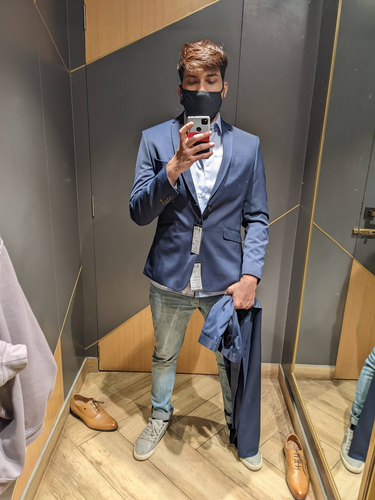

In [ ]:
img

In [ ]:
img.size

(375, 500)

In [ ]:
# import dlib
# detector = dlib.get_frontal_face_detector()
# rects = detector(img_raw,0)

# rect = rects[0]
# startX = rect.left()
# startY = rect.top()
# endX = rect.right()
# endY = rect.bottom()

# cv2.rectangle(img_raw, (startX, startY), (endX, endY), (0,0,255), 2)

## results

In [ ]:
dets.shape

(2, 15)

## Image rejection

In [ ]:
dets.shape

(1, 15)

In [ ]:
bboxs = dets

In [ ]:
def ladnmarks(rec,h,w):
    landmarks_top = rec[1]
    landmarks_bottom = rec[3]
    landmarks_left = rec[0]
    landmarks_right = rec[2]

    # expand bbox
    top = int(landmarks_top - 0.8 * (landmarks_bottom - landmarks_top))
    bottom = int(landmarks_bottom + 0.3 * (landmarks_bottom - landmarks_top))
    left = int(landmarks_left - 0.3 * (landmarks_right - landmarks_left))
    right = int(landmarks_right + 0.3 * (landmarks_right - landmarks_left))

    if bottom - top > right - left:
        left -= ((bottom - top) - (right - left)) // 2
        right = left + (bottom - top)
    else:
        top -= ((right - left) - (bottom - top)) // 2
        bottom = top + (right - left)
        
    left = max(0, left)
    right = min(right, w-1)
    top = max(0, top)
    bottom = min(bottom, h-1)

    return (left,top,right,bottom)

In [ ]:
def overlap(rec1, rec2,h,w):
  rec1 = ladnmarks(rec1,h,w)
  rec2 = ladnmarks(rec2,h,w)
  if (rec2[2] > rec1[0] and rec2[2] < rec1[2]) or \
     (rec2[0] > rec1[0] and rec2[0] < rec1[2]):
    x_match = True
  else:
    x_match = False
  if (rec2[3] > rec1[1] and rec2[3] < rec1[3]) or \
     (rec2[1] > rec1[1] and rec2[1] < rec1[3]):
    y_match = True
  else:
    y_match = False
  if x_match and y_match:
    return True
  else:
    return False

In [ ]:
gray = cv2.cvtColor(img_raw, cv2.COLOR_RGB2GRAY)
blurred = cv2.GaussianBlur(gray, (25, 25), 0)
no_text = gray * ((gray/blurred)>0.80)                     # select background only
no_text[no_text<10] = no_text[no_text>20].mean()           # convert black pixels to mean value
no_bright = no_text.copy()
no_bright[no_bright>220] = no_bright[no_bright<220].mean() # disregard bright pixels

std = no_bright.std()
bright = (no_text>220).sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
std

42.87761750976616

In [ ]:
bright

1587

In [ ]:
dets.shape

(3, 15)

In [ ]:
dets_1 = []

In [ ]:
for b in dets:
    if b[4] < 0.6:
        continue
    else:
        dets_1.append(b)

In [ ]:
len(dets_1)

2

In [ ]:
dets = np.array(dets_1)

(2, 15)

In [ ]:
quality = True
status = "Accepted"
area=True

In [ ]:
if dets.shape[0] == 0:
    status = "Rejected:No Face"
elif dets.shape[0] > 2:
    status = "Rejected: Multiple Face_two_plus"
elif dets.shape[0] == 2:
    if overlap(dets[0], dets[1],img_raw.shape[0],img_raw.shape[1]):
        status = "Rejected: Intersecting Faces"
elif std>36 and bright>15000:
    status="Rejected: Uneven Illumination"
else:
    status = "Accepted"

In [ ]:
status

'Rejected: Multiple Face_two_plus'

## Cropping

In [ ]:
def gender__crop(image, landmarks):
        landmarks_top = np.min(landmarks[:, 1])
        landmarks_bottom = np.max(landmarks[:, 1])
        landmarks_left = np.min(landmarks[:, 0])
        landmarks_right = np.max(landmarks[:, 0])

        # expand bbox
        # top = int(landmarks_top - 0.8 * (landmarks_bottom - landmarks_top))
        # bottom = int(landmarks_bottom + 0.3 * (landmarks_bottom - landmarks_top))
        left = int(landmarks_left - 0.5 * (landmarks_right - landmarks_left))
        right = int(landmarks_right + 0.5 * (landmarks_right - landmarks_left))
        scale = ((landmarks_right - landmarks_left)*218)/178
        padding = ((landmarks_bottom - landmarks_top)-(landmarks_bottom - landmarks_top)*scale)/2
        top = int(landmarks_top - padding)
        bottom = int(landmarks_bottom + padding)


        if bottom - top > right - left:
            left -= ((bottom - top) - (right - left)) // 2
            right = left + (bottom - top)
        else:
            top -= ((right - left) - (bottom - top)) // 2
            bottom = top + (right - left)

        image_crop = np.ones((bottom - top + 1, right - left + 1, 3), np.uint8) * 0

        h, w = image.shape[:2]
        left_white = max(0, -left)
        left = max(0, left)
        right = min(right, w-1)
        right_white = left_white + (right-left)
        top_white = max(0, -top)
        top = max(0, top)
        bottom = min(bottom, h-1)
        bottom_white = top_white + (bottom - top)

        image_crop[top_white:bottom_white+1, left_white:right_white+1] = image[top:bottom+1, left:right+1].copy()
        return  image_crop

In [121]:
def Relcrop(image, b):
    landmarks_top = b[1]
    landmarks_bottom = b[3]
    landmarks_left = b[0]
    landmarks_right = b[2]
    top = int(landmarks_top - 0.3 * (landmarks_bottom - landmarks_top))
    bottom = int(landmarks_bottom + 0.2 * (landmarks_bottom - landmarks_top))
    left = int(landmarks_left - 0.2 * (landmarks_right - landmarks_left))
    right = int(landmarks_right + 0.2 * (landmarks_right - landmarks_left))
    if bottom - top > right - left:
        left -= ((bottom - top) - (right - left)) // 2
        right = left + (bottom - top)
    else:
        top -= ((right - left) - (bottom - top)) // 2
        bottom = top + (right - left)
    image_crop = np.ones(
        (bottom - top + 1, right - left + 1, 3), np.uint8) * 255
    h, w = image.shape[:2]
    left_white = max(0, -left)
    left = max(0, left)
    right = min(right, w-1)
    right_white = left_white + (right-left)
    top_white = max(0, -top)
    top = max(0, top)
    bottom = min(bottom, h-1)
    bottom_white = top_white + (bottom - top)
    image_crop[top_white:bottom_white+1, left_white:right_white +
                1] = image[top:bottom+1, left:right+1].copy()
    return image_crop

In [122]:
k = Relcrop(img_raw, dets[0])

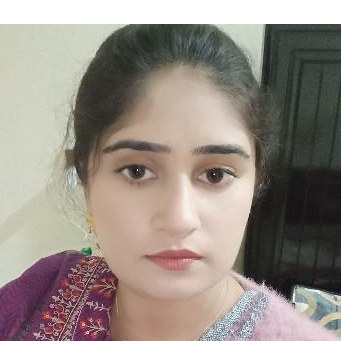

In [123]:
Image.fromarray(k)

In [ ]:
deltaY = int((endY-startY)/1)
deltaX = int((endX-startX)/1)
startX = max(0, startX)
startY = max(0, startY)
endX = min(endX, img_raw.shape[1])
endY = min(endY, img_raw.shape[0])

In [ ]:
w = endX - startX
h = endY - startY

left = max(0, startX-deltaX)
top = max(0, startY-deltaY)
right = min(startX+w+deltaX, img_raw.shape[1])
bottom = min(startY+h+deltaY, img_raw.shape[0])

In [ ]:
imm = Image.fromarray(img_raw) 

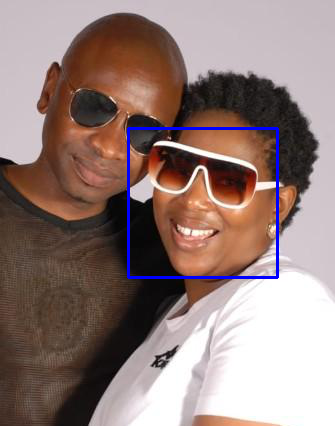

In [ ]:
imm.crop((left,top,right,bottom))

In [ ]:
dets.shape

(3, 15)

In [ ]:
dets[2][4]

0.3157472610473633

In [ ]:
for b in dets:
    if b[4] < 0.6:
        continue
        print('NONO')
    text = "{:.4f}".format(b[4])
    b = list(map(int, b))
    cv2.rectangle(img_raw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 2)
    cx = b[0]
    cy = b[1] + 12
    cv2.putText(img_raw, text, (cx, cy),
                cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255))

    # landms
    cv2.circle(img_raw, (b[5], b[6]), 1, (0, 0, 255), 4) #mouth right
    cv2.circle(img_raw, (b[7], b[8]), 1, (0, 255, 255), 4) #eye right
    cv2.circle(img_raw, (b[9], b[10]), 1, (255, 0, 255), 4) #nose center
    cv2.circle(img_raw, (b[11], b[12]), 1, (0, 255, 0), 4) #mouth left
    cv2.circle(img_raw, (b[13], b[14]), 1, (255, 0, 0), 4) #eye left

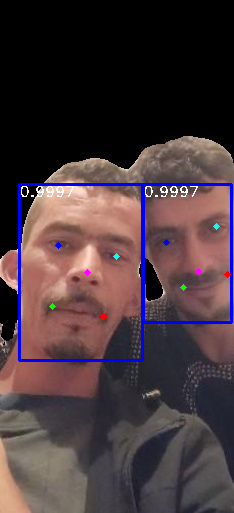

In [ ]:
Image.fromarray(img_raw)

In [ ]:
startX = dets[0][0]
startY = dets[0][1]
endX = dets[0][2]
endY = dets[0][3]
# ensure the bounding box coordinates fall within the spatial
# dimensions of the image
# adjusting coordinates
deltaY = int((endY-startY)/1)
deltaX = int((endX-startX)/1)
startX = max(0, startX)
startY = max(0, startY)
endX = min(endX, img_raw.shape[1])
endY = min(endY, img_raw.shape[0])
# adjust the starting coordinates
# compute the width and height of the bounding box
w = endX - startX
h = endY - startY
# return our bounding box coordinates

In [ ]:
(x,y,w,h,dy,dx) = (startX, startY, w, h,deltaY,deltaX)
left = max(0, x-dx)
top = max(0, y-dy)
right = min(x+w+dx, img_raw.shape[1])
bottom = min(y+h+dy, img_raw.shape[0])

In [ ]:
right

373

In [ ]:
img_raw.shape

(500, 373, 3)

In [ ]:
imm = Image.fromarray(img_raw) 

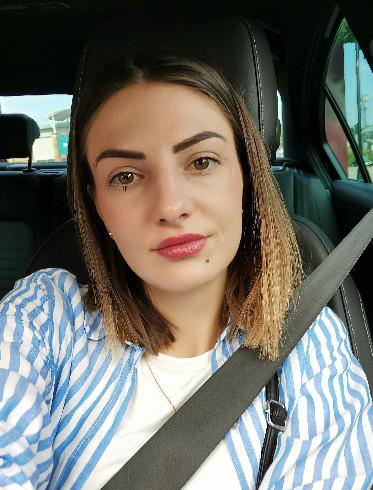

In [ ]:
imm.crop((left,top,right,bottom))

In [ ]:
img = Image.open(requests.get(url2, stream=True).raw).convert('RGB')
print(img.size)
#img = Image.open('/content/drive/MyDrive/facecartoon/face.jpg').convert('RGB').resize((500,400))
img_raw = np.array(img)
img = Image.fromarray(img_raw)

(373, 500)


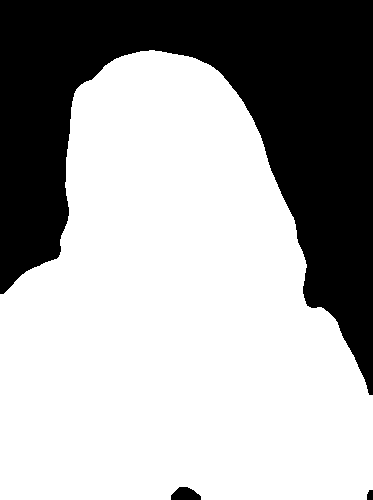

In [ ]:
img

In [ ]:
dets.shape

(1, 15)

In [ ]:
#image incoming is pillow image
for b in dets[:1]:
    mouth_right = np.array([b[13], b[14]])
    mouth_left = np.array([b[11], b[12]])
    eye_right = np.array([b[7], b[8]])
    eye_left = np.array([b[5], b[6]])

    eye_avg = (eye_left + eye_right) * 0.5
    eye_to_eye = eye_right - eye_left
    mouth_avg = (mouth_left + mouth_right) * 0.5
    eye_to_mouth = mouth_avg - eye_avg

    # Choose oriented crop rectangle.
    x = eye_to_eye - np.flipud(eye_to_mouth) * [-1, 1]
    x /= np.hypot(*x)
    x *= max(np.hypot(*eye_to_eye) * 2.0, np.hypot(*eye_to_mouth) * 1.8)
    y = np.flipud(x) * [-1, 1]
    c = eye_avg + eye_to_mouth * 0.1
    quad = np.stack([c - x - y, c - x + y, c + x + y, c + x - y])
    qsize = np.hypot(*x) * 2

    enable_padding = True
    output_size = 512
    transform_size = 256

    # Shrink.
    shrink = int(np.floor(qsize / output_size * 0.5))
    print(shrink)
    if shrink > 1:
        rsize = (int(np.rint(float(img.size[0]) / shrink)), int(np.rint(float(img.size[1]) / shrink)))
        img = img.resize(rsize, Image.ANTIALIAS)
        quad /= shrink
        qsize /= shrink


    # Crop.
    border = max(int(np.rint(qsize * 0.2)), 3)
    crop = (int(np.floor(min(quad[:, 0]))), int(np.floor(min(quad[:, 1]))), int(np.ceil(max(quad[:, 0]))),
            int(np.ceil(max(quad[:, 1]))))
    print(type(crop))
    crop = (max(crop[0] - border, 0), max(crop[1] - border, 0), min(crop[2] + border, img.size[0]),
            min(crop[3] + border, img.size[1]))
    if crop[2] - crop[0] < img.size[0] or crop[3] - crop[1] < img.size[1]:
        print('YES')
        img = img.crop(crop)
        quad -= crop[0:2]

    import scipy
    import scipy.ndimage
    # Pad.
    pad = (int(np.floor(min(quad[:, 0]))), int(np.floor(min(quad[:, 1]))), int(np.ceil(max(quad[:, 0]))),
            int(np.ceil(max(quad[:, 1]))))
    pad = (max(-pad[0] + border, 0), max(-pad[1] + border, 0), max(pad[2] - img.size[0] + border, 0),
            max(pad[3] - img.size[1] + border, 0))
    # if enable_padding and max(pad) > border - 4:
    #     pad = np.maximum(pad, int(np.rint(qsize * 0.3)))
    #     img = np.pad(np.float32(img), ((pad[1], pad[3]), (pad[0], pad[2]), (0, 0)), 'reflect')
    #     h, w, _ = img.shape
    #     y, x, _ = np.ogrid[:h, :w, :1]
    #     mask = np.maximum(1.0 - np.minimum(np.float32(x) / pad[0], np.float32(w - 1 - x) / pad[2]),
    #                         1.0 - np.minimum(np.float32(y) / pad[1], np.float32(h - 1 - y) / pad[3]))
    #     blur = qsize * 0.02
    #     img += (scipy.ndimage.gaussian_filter(img, [blur, blur, 0]) - img) * np.clip(mask * 3.0 + 1.0, 0.0, 1.0)
    #     img += (np.median(img, axis=(0, 1)) - img) * np.clip(mask, 0.0, 1.0)
    #     img = Image.fromarray(np.uint8(np.clip(np.rint(img), 0, 255)), 'RGB')
    #     quad += pad[:2]

    # Transform.
    img = img.transform((transform_size, transform_size), Image.QUAD, (quad + 0.5).flatten(), Image.BILINEAR, fillcolor =(255,255,255))
    if output_size < transform_size:
        img = img.resize((output_size, output_size), Image.ANTIALIAS)

0
<class 'tuple'>
YES


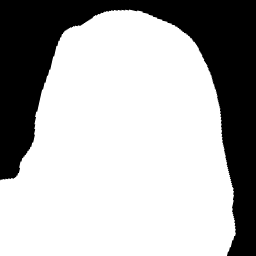

In [ ]:
img

In [ ]:
img.size

(256, 256)

In [ ]:
np.array(img.convert('L')).shape

(256, 256)

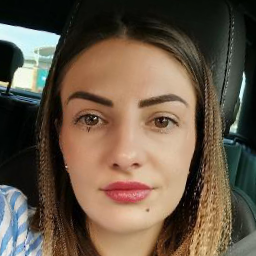

In [ ]:
img

In [ ]:
img.size

(236, 280)